In [2]:
!pip install matplotlib
!pip install tensorflow
!pip install keras
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dropout, Dense, Activation
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

  Using cached matplotlib-3.3.4-cp36-cp36m-manylinux1_x86_64.whl (11.5 MB)
  Using cached kiwisolver-1.3.1-cp36-cp36m-manylinux1_x86_64.whl (1.1 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
You should consider upgrading via the '/usr/local/bin/python3.6 -m pip install --upgrade pip' command.
  Using cached tensorflow-2.6.2-cp36-cp36m-manylinux2010_x86_64.whl (458.3 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached h5py-3.1.0-cp36-cp36m-manylinux1_x86_64.whl (4.0 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached tensorboard-2.6.0-py3-none-any.whl (5.6 MB)
  Using cached numpy-1.19.5-cp36-cp36m-manylinux2010_x86_64.whl (14.8 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorflow_estimator-2.6.0-py2.py3-none-any.whl (462 kB)
  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)
  Using cached clang-5.0-py3-none-any.wh

Read csv

In [3]:
# Host runtinme
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv('/content/drive/My Drive/opera-dl/data/opera_dataset_1w_10min.csv',parse_dates=['timestamp'])

# Local runtime
df = pd.read_csv('opera_dataset_1w_10min.csv',parse_dates=['timestamp'])



Prepare data (samples, time steps, features) and normalise

In [4]:
#small sample for debugging
#df = df[:10000]

# 90 minutes (9 * 10 minutes)
time_steps = 9

# 120 minutes (12 * 10 minutes)
#time_steps = 12

# Average only
features=['Rad_avg','Tamb_avg']

# Average, max, min and std dev
#features=['Rad_avg','Tamb_avg','Tmod_avg','Rad_max','Tamb_max','Tmod_max','Rad_min','Tamb_min','Tmod_min','Rad_std','Tamb_std','Tmod_std']

X = np.zeros((len(df), time_steps, len(features)))

for ix in range(time_steps):
  X[:,ix,:] = df[features].shift(ix)

#Drop NaN
X = X[time_steps:]
y = df['Pa1'][time_steps:]

# Normalise
X_norm=X
scalers_X = {}
for i in range(X.shape[2]):
    scalers_X[i] = StandardScaler()
    X_norm[:, :, i] = scalers_X[i].fit_transform(X[:, :, i]) 

scaler_y = MinMaxScaler()
y_norm = scaler_y.fit_transform(y.values.reshape(-1, 1))

pd.DataFrame(X_norm.reshape(-1, 1)).to_csv("univer_2param_xnorm.csv")
pd.DataFrame(y_norm).to_csv("univer_2_param_ynorm.csv")



In [5]:
#fig, axs = plt.subplots(3)
#fig.set_figheight(30)
#fig.set_figwidth(15)

#axs[0].plot(df.index,X_norm[0])
#axs[0].plot(X_norm[1])
#axs[0].plot(y_norm)

X.shape[2]




2

Model

In [6]:
# batch size = 1 week of data
b_size = 1008

n_epochs = 20

def baseline_model():
  # create model
  model = Sequential()
  model.add(Conv1D(16,2,padding='valid',activation='relu',strides=1, input_shape=(X_norm.shape[1], X_norm.shape[2])))
  #model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(32,2,padding='valid',activation='relu',strides=1))
  #model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(64,2,padding='valid',activation='relu',strides=1))
  #model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))
  #model.add(LSTM(32, return_sequences=True,input_shape=(X_norm.shape[1], X_norm.shape[2])))
  model.add(LSTM(32, return_sequences=True))
  model.add(Dropout(0.25))
  model.add(LSTM(32))
  model.add(Dropout(0.25))
  model.add(Dense(1))
  model.add(Activation('relu'))
	# Compile model
  model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0003), metrics=['mean_squared_error','mean_absolute_error'])
	#model.compile(loss='mean_squared_error', optimizer='adam')
  return model

# evaluate model
opera_estimator = KerasRegressor(build_fn=baseline_model, epochs=n_epochs, batch_size=b_size, verbose=0)
#kfold = KFold(n_splits=10)



Cross validation

In [7]:

# X normalised
#scores_predict = cross_val_predict(estimator, X_norm, y_norm, cv=cv_n)
 
# X not normalised
#scores_predict = cross_val_predict(estimator, X, y_norm, cv=cv_n)

#scores_predict_denorm = scaler_y.inverse_transform(scores_predict.reshape(-1, 1))



fit and save for model transfer

In [8]:
opera_estimator.fit(X_norm, y_norm)
opera_estimator.model.save('OperaEstimator2param20211209.h5')


/usr/local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:


scores_predict = cross_val_predict(opera_estimator, X_norm, y_norm, cv=cv_n)
scores_predict_denorm = scaler_y.inverse_transform(scores_predict.reshape(-1, 1))

#scores_predict = estimator.predict(X_norm)
#pd.DataFrame(scores_predict).to_csv("univer2param_prediction.csv")
#scores_predict_denorm = scaler_y.inverse_transform(scores_predict.reshape(-1, 1))
#pd.DataFrame(scores_predict_denorm).to_csv("univer2param_prediction_denorm.csv")


Metrics

In [11]:
RMSE = np.sqrt(mean_squared_error(y,scores_predict_denorm))
MAE = mean_absolute_error(y,scores_predict_denorm)
R2 = r2_score(y,scores_predict_denorm)
print(RMSE,MAE, R2)

584.7240366390788 331.12979493094485 0.9955953803910786


Results:
- RMSE=520.5W
- MAE=278.7W
- R2=0.9959220155387354

In [12]:
#plt.scatter(y, scores_predict_denorm, s=1)
#plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
 

Performance

In [13]:
#scores_eval = cross_validate(estimator, X_norm, y_norm, cv=cv_n)
#print(scores_eval['fit_time'].mean(), scores_eval['score_time'].mean(), scores_eval['test_score'].mean())

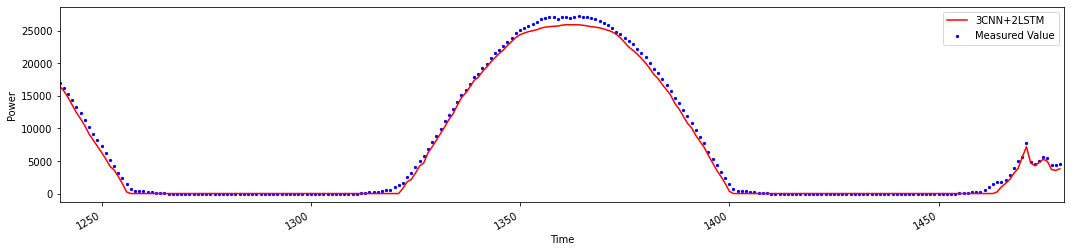

In [14]:
X = df.drop('Pa1', axis=1)
#y = df['Pa1']

xplot_min = 1240
xplot_max = 1480

fig, axes = plt.subplots(figsize=(18, 4))
axes.scatter(X.index[xplot_min:xplot_max],y[xplot_min:xplot_max],color="blue",label="Measured Value",s=5)
axes.plot(X.index[xplot_min:xplot_max],scores_predict_denorm[xplot_min:xplot_max], color="red",label="3CNN+2LSTM")
axes.legend()
axes.set_xlim(X.index[xplot_min],X.index[xplot_max])
axes.set_xlabel('Time')
axes.set_ylabel('Power')  


fig.autofmt_xdate()
plt.show()

#### Stranger learning

We will try to nowcast the output power generation of the Milano SolarTech Lab system with the Univer model, without re-training the model

In [8]:
estimator_b_solartech_on_univer=keras.models.load_model('SolarTechEstimator20211209.h5')
domain_scores_predict = estimator_b_solartech_on_univer.predict(X_norm)
domain_scores_predict_denorm = scaler_y.inverse_transform(domain_scores_predict.reshape(-1, 1))
pd.DataFrame(domain_scores_predict_denorm).to_csv("solartech_on_univer_prediction_denorm.csv")

In [9]:
#RMSE = np.sqrt(mean_squared_error(y,domain_scores_predict_denorm))
#MAE = mean_absolute_error(y,domain_scores_predict_denorm)
#R2 = r2_score(y,domain_scores_predict_denorm)
#print(RMSE,MAE, R2)

NMSE = np.sqrt(mean_squared_error(y_norm,domain_scores_predict))
NMAE = mean_absolute_error(y_norm,domain_scores_predict)
print(NMSE,NMAE)

0.058084160660062605 0.035615771718547684


Results:
- RMSE=2301.35W
- MAE=1539.10W
- R2=0.9317702640948087

Fine-tuned Learning

In [17]:
estimator_c_solartech_univer=opera_estimator
estimator_c_solartech_univer.model=keras.models.load_model('SolarTechEstimator20211206.h5')
finetuned_scores_predict = cross_val_predict(estimator_c_solartech_univer, X_norm, y_norm, cv=cv_n)
finetuned_scores_predict_denorm = scaler_y.inverse_transform(finetuned_scores_predict.reshape(-1, 1))
RMSE = np.sqrt(mean_squared_error(y,finetuned_scores_predict_denorm))
MAE = mean_absolute_error(y,finetuned_scores_predict_denorm)
R2 = r2_score(y,finetuned_scores_predict_denorm)
print(RMSE,MAE, R2)

/usr/local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


549.7001606918678 309.31345266318283 0.9961072345086242


Results:
- RMSE=513.76W
- MAE=279.57W
- R2=0.996599690513932

In [9]:
n_epochs_learning=50

estimator_learning=keras.models.load_model('SolarTechEstimator20211209.h5')
fitted_model_transfer = estimator_learning.fit(X_norm, y_norm, validation_split=0.33, epochs=n_epochs_learning, batch_size=b_size, shuffle=True, verbose=0)


In [10]:

NMSE_transfer = fitted_model_transfer.history['val_mean_squared_error'][-1]
NMAE_transfer = fitted_model_transfer.history['val_mean_absolute_error'][-1]

In [11]:
print(NMSE_transfer, NMAE_transfer)

0.0009555931901559234 0.016321225091814995


In [11]:
n_epochs_learning=50

t_model = Sequential()
t_model.add(Conv1D(16,2,padding='valid',activation='relu',strides=1, input_shape=(X_norm.shape[1], X_norm.shape[2])))
  #model.add(MaxPooling1D(pool_size=2))
t_model.add(Conv1D(32,2,padding='valid',activation='relu',strides=1))
  #model.add(MaxPooling1D(pool_size=2))
t_model.add(Conv1D(64,2,padding='valid',activation='relu',strides=1))
  #model.add(MaxPooling1D(pool_size=2))
t_model.add(Dropout(0.25))
t_model.add(LSTM(32, return_sequences=True))
t_model.add(Dropout(0.25))
t_model.add(LSTM(32))
t_model.add(Dropout(0.25))
t_model.add(Dense(1))
t_model.add(Activation('relu'))
  # Compile model
  #model.compile(loss='mae', optimizer=Adam(lr=0.0003), metrics=['mae'])
  #model.compile(loss='mean_squared_error', optimizer='adam')
t_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0003), metrics=['mean_squared_error','mean_absolute_error'])


fitted_model = t_model.fit(X_norm, y_norm, validation_split=0.33, epochs=n_epochs_learning, batch_size=b_size, shuffle=True, verbose=0)


In [12]:
NMSE = fitted_model.history['val_mean_squared_error'][-1]
NMAE = fitted_model.history['val_mean_absolute_error'][-1]

In [13]:
print(NMSE, NMAE)

0.0014597034314647317 0.01928296685218811


0.0014597034314647317 0.01928296685218811